SETUP AND OBSERVATIONAL ANALYSIS

In [87]:
# Importing libraries/functions to be used
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split

In [88]:
# Import dataset from yahoo finance consisting of [Date, Opening Price, Closing Price]
dataset = yf.download(tickers = "^GSPC", period="1y")
dataset = dataset[['Open', 'Close']]
dataset = dataset.reset_index()
dataset

[*********************100%%**********************]  1 of 1 completed


,Date,Open,Close
0,2023-10-23,4210.399902,4217.040039
1,2023-10-24,4235.790039,4247.680176
2,2023-10-25,4232.419922,4186.770020
3,2023-10-26,4175.990234,4137.229980
4,2023-10-27,4152.930176,4117.370117
...,...,...,...
247,2024-10-16,5816.580078,5842.470215
248,2024-10-17,5875.620117,5841.470215
249,2024-10-18,5859.430176,5864.669922
250,2024-10-21,5857.819824,5853.979980


In [89]:
# Transform the raw data into a pandas dataframe consisting of [Date, OPS]
# OPS = ((Opening Price - Closing Price of previous day) / Closing Price of previous day) * 100
# i.e. it refers to the percentage change in price overnight
ops = []
for i in range(1, len(dataset['Open'] + 1)):
    result = ((dataset['Open'][i] - dataset['Close'][i-1]) / dataset['Close'][i-1]) * 100
    ops.append(result)
ops = pd.DataFrame({'OPS': ops})

time_series = pd.concat([dataset['Date'], ops], axis=1)
time_series = time_series.dropna()
#time_series['OPS'] = time_series['OPS'].shift(1)
#time_series = time_series.drop(0)
#time_series = time_series.drop(index=1)
#time_series = time_series.reset_index()
#time_series = time_series.drop(['index'], axis=1)
time_series

,Date,OPS
0,2023-10-23,0.444625
1,2023-10-24,-0.359261
2,2023-10-25,-0.257473
3,2023-10-26,0.379486
4,2023-10-27,0.534808
...,...,...
246,2024-10-15,0.022704
247,2024-10-16,0.567395
248,2024-10-17,0.307456
249,2024-10-18,-0.116803


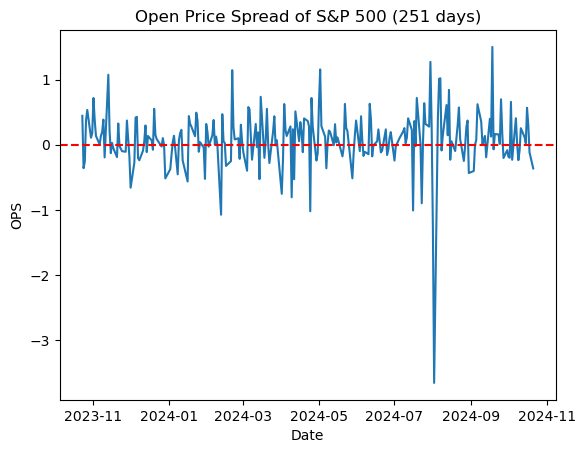

In [90]:
# Plotting the time series data (OPS) for observing trends and seasons
plt.plot(time_series['Date'], time_series['OPS'])
plt.axhline(y=0, linestyle='--', color='red')
plt.title('Open Price Spread of S&P 500 (' + str(len(time_series['OPS'])) + ' days)')
plt.xlabel('Date')
plt.ylabel('OPS')
plt.show()

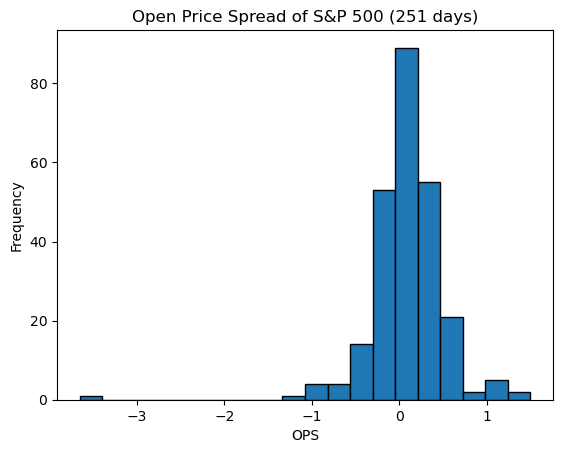

In [91]:
# Plotting the spread of OPS
plt.hist(time_series['OPS'], bins=20, edgecolor="black")
plt.title('Open Price Spread of S&P 500 (' + str(len(time_series['OPS'])) + ' days)')
plt.xlabel('OPS')
plt.ylabel('Frequency')
plt.show()

ARIMA MODEL

These were used as guides during the creation of this model:

Forecasting Time Series with Auto-Arima, Data Science Portfolio, alldatascience.com <https://www.alldatascience.com/time-series/forecasting-time-series-with-auto-arima/>

How to Create an ARIMA Model for Time Series Forecasting in Python, Jason Brownlee, machinelearningmaster.com <https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/>

Interrupted time series analysis using autoregressive integrated moving average (ARIMA) models: a guide for evaluating large-scale health interventions, Schaffer A et al., PubMed <https://pmc.ncbi.nlm.nih.gov/articles/PMC7986567/>

In [92]:
# Check to see if data is stationary using the Augmented Dicky Fuller Test (adfuller)
# Stationary data is required for timeseries analysis/prediction
data = time_series['OPS']
stationary_check = adfuller(data)
print('ADF Statistic: ', stationary_check[0])
print('p-value: ', stationary_check[1])
if(stationary_check[1] < 0.05):
    print('Data is stationary')
else:
    print('Data is not stationary')

ADF Statistic:  -8.686445046031537
p-value:  4.1509930993540186e-14
Data is stationary


c:\Users\olive\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


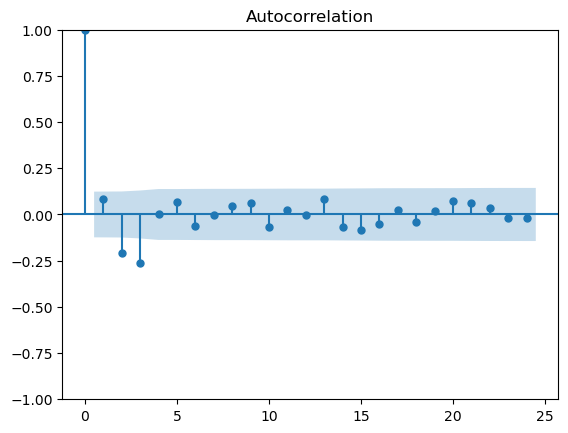

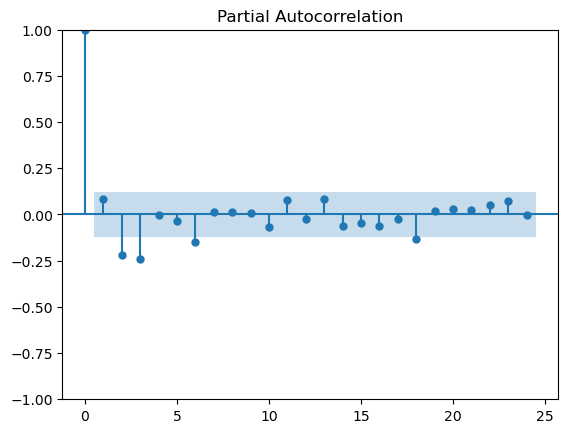

In [93]:
# Autocorrelation and partial autocorrelation graphs
plot_acf(data)
plot_pacf(data)
plt.show()

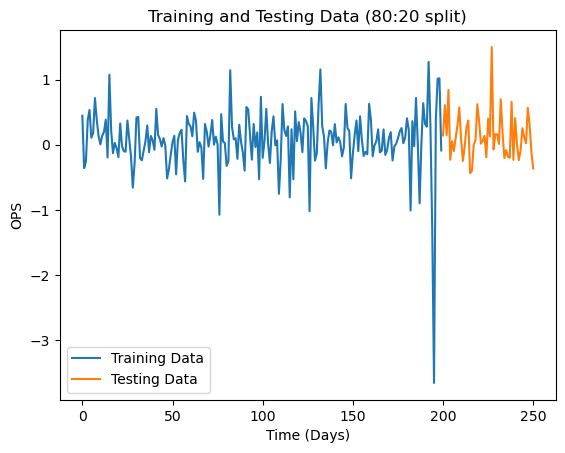

In [94]:
# Split data into 80% training set and 20% testing set
train_data, test_data = train_test_split(data, test_size=0.20, shuffle=False)
plt.plot(train_data, label="Training Data")
plt.plot(test_data, label="Testing Data")
plt.title("Training and Testing Data (80:20 split)")
plt.xlabel("Time (Days)")
plt.ylabel("OPS")
plt.legend()
plt.show()

In [95]:
# Due to being unable to determine the p and q parameters for the arima model, 
# an auto-arima algorithm will be used which selects the p, d and q parameters automatically

# Fitting model
model = auto_arima(train_data, seasonal=False, stepwise=True)
print(model.order)
print(model.summary())

(3, 0, 0)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -115.652
Date:                Wed, 23 Oct 2024   AIC                            241.305
Time:                        09:59:07   BIC                            257.796
Sample:                             0   HQIC                           247.979
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1000      0.042      2.399      0.016       0.018       0.182
ar.L1          0.0608      0.078      0.780      0.435      -0.092       0.214
ar.L2         -0.2317      0.081     -2.85

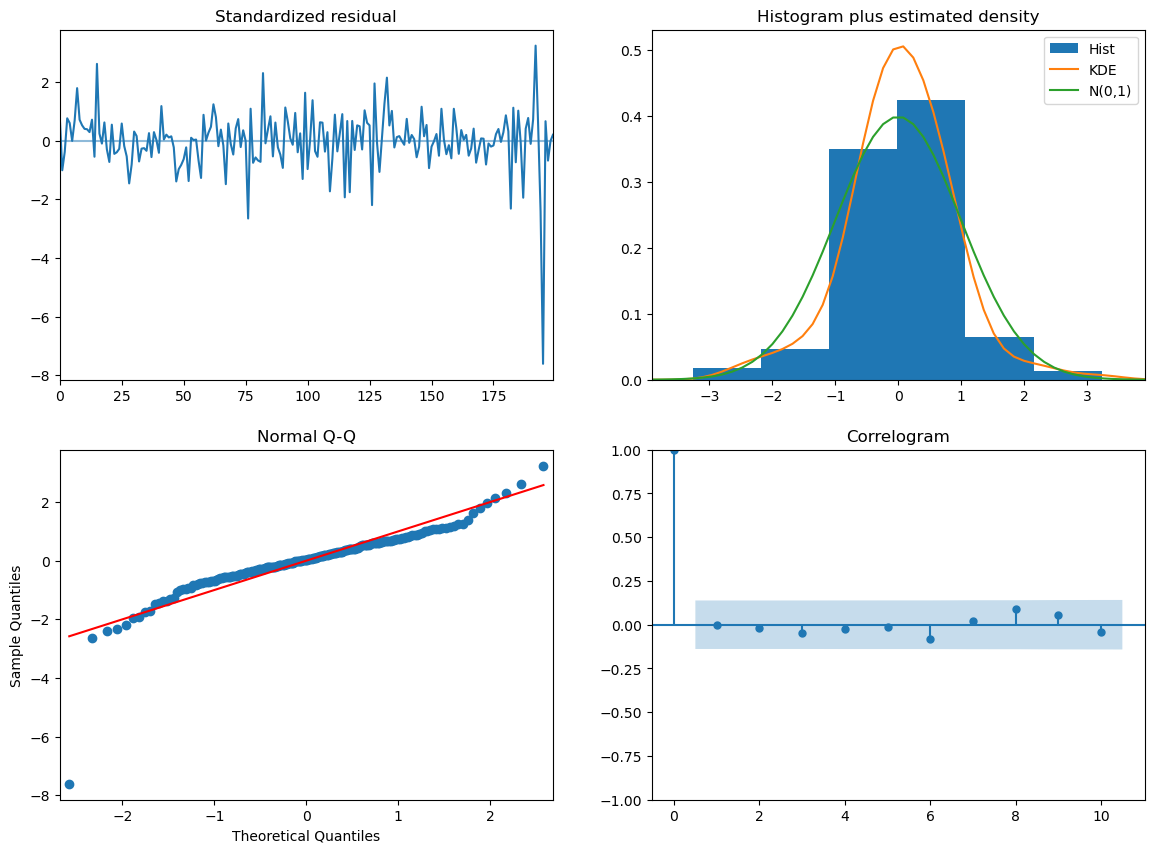

In [96]:
# Plotting diagnostics/residual plots
model.plot_diagnostics(figsize=(14,10))
plt.show()

PREDICTION

In [97]:
# Making prediction
prediction, confint = model.predict(n_periods=len(test_data), return_conf_int=True)
print(prediction)

200   -0.406638
201   -0.171228
202    0.206634
203    0.258501
204    0.112586
205   -0.007055
206    0.005920
207    0.072562
208    0.104876
209    0.088010
210    0.062081
211    0.055967
212    0.066010
213    0.074814
214    0.074620
215    0.069944
216    0.067404
217    0.068383
218    0.070254
219    0.070804
220    0.070149
221    0.069492
222    0.069460
223    0.069782
224    0.069980
225    0.069926
226    0.069793
227    0.069746
228    0.069788
229    0.069836
230    0.069842
231    0.069820
232    0.069805
233    0.069807
234    0.069817
235    0.069821
236    0.069818
237    0.069814
238    0.069814
239    0.069815
240    0.069816
241    0.069816
242    0.069816
243    0.069815
244    0.069815
245    0.069816
246    0.069816
247    0.069816
248    0.069816
249    0.069816
250    0.069816
dtype: float64


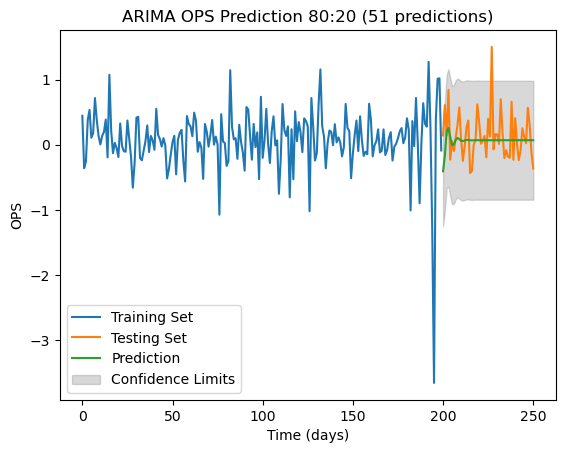

In [98]:
# Saving confidence limits
cf= pd.DataFrame(confint)

# Plot final results
plt.plot(train_data, label='Training Set')
plt.plot(test_data, label='Testing Set')
plt.plot(prediction, label='Prediction')
plt.fill_between(prediction.index,cf[0], cf[1], color='grey', alpha=0.3, label='Confidence Limits')
plt.title('ARIMA OPS Prediction 80:20 (' + str(len(prediction)) + ' predictions)')
plt.xlabel('Time (days)')
plt.ylabel('OPS')
plt.legend()
plt.show()

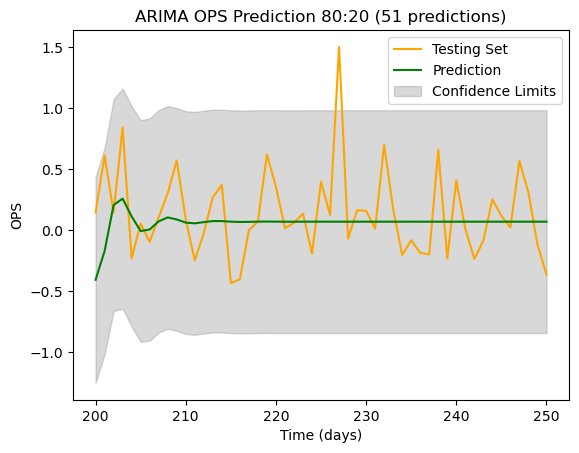

In [99]:
# Plot Test set and prediction to get a close up comparison
plt.plot(test_data, label='Testing Set', color='orange')
plt.plot(prediction, label='Prediction', color='green')
plt.fill_between(prediction.index,cf[0], cf[1], color='grey', alpha=0.3, label='Confidence Limits')
plt.title('ARIMA OPS Prediction 80:20 (' + str(len(prediction)) + ' predictions)')
plt.xlabel('Time (days)')
plt.ylabel('OPS')
plt.legend()
plt.show()

EVALUATION

In [100]:
# Calculate accuracy measures mean squared error, mean absolute error and r squared value
mse = mean_squared_error(test_data, prediction)
mae = mean_absolute_error(test_data, prediction)
#mape = mean_absolute_percentage_error(test_data, prediction)
r2 = r2_score(test_data, prediction)
def calcsmape(actual, forecast):
    return 1/len(actual) * np.sum(2 * np.abs(forecast-actual) / (np.abs(actual) + np.abs(forecast)))
#smae = calcsmape(test_data, prediction)

print(mse)
print(mae)
#print(mape)
print(r2)
#print(smae)

0.13548993569804996
0.2673979322012643
-0.08604121052247948


In [101]:
# Save accuracy measures in a dataframe/table
accuracy_table = pd.DataFrame({'Train:Test Split' : "80:20",'Mean Squared Error' : mse, 'Mean Absolute Error' : mae, 'R-Squared Value' : r2}, index=["80:20"])
accuracy_table = accuracy_table.set_index('Train:Test Split')
accuracy_table

,Mean Squared Error,Mean Absolute Error,R-Squared Value
Train:Test Split,,,
80:20,0.13549,0.267398,-0.086041


The experiment was then repeated for smaller testing/prediction sizes and bigger training sizes

TEST SIZE = 10%

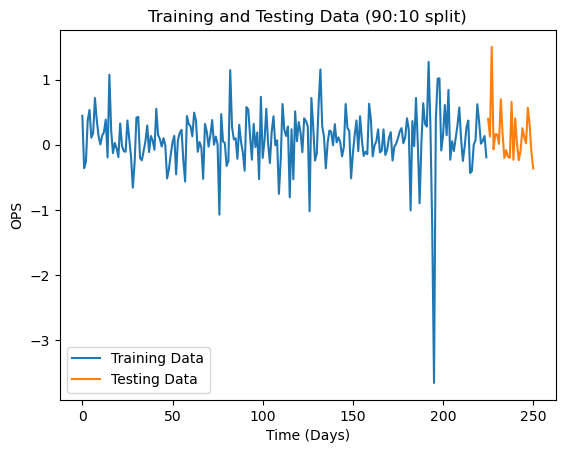

In [102]:
# Split data
train_data, test_data = train_test_split(data, test_size=0.10, shuffle=False)
plt.plot(train_data, label="Training Data")
plt.plot(test_data, label="Testing Data")
plt.title("Training and Testing Data (90:10 split)")
plt.xlabel("Time (Days)")
plt.ylabel("OPS")
plt.legend()
plt.show()

(3, 0, 0)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  225
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -125.005
Date:                Wed, 23 Oct 2024   AIC                            260.011
Time:                        09:59:09   BIC                            277.091
Sample:                             0   HQIC                           266.904
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1085      0.039      2.795      0.005       0.032       0.185
ar.L1          0.0678      0.072      0.943      0.346      -0.073       0.209
ar.L2         -0.2151      0.078     -2.77

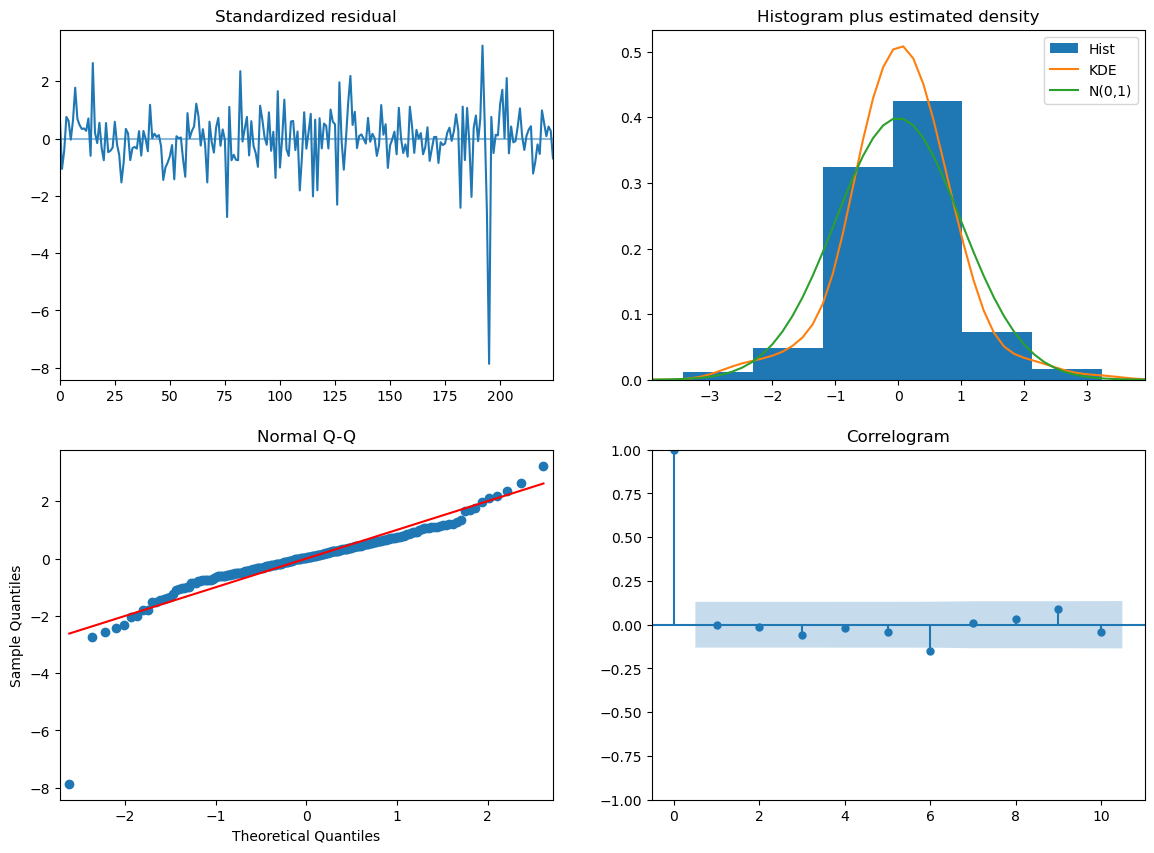

In [103]:
# Fit model
model = auto_arima(train_data, seasonal=False, stepwise=True)
print(model.order)
print(model.summary())
model.plot_diagnostics(figsize=(14,10))
plt.show()

In [104]:
# Make prediction
prediction, confint = model.predict(n_periods=len(test_data), return_conf_int=True)
cf = pd.DataFrame(confint)
print(prediction)

225    0.051980
226    0.121100
227    0.151378
228    0.080360
229    0.052550
230    0.058722
231    0.082055
232    0.088940
233    0.082916
234    0.075464
235    0.074612
236    0.077594
237    0.079756
238    0.079465
239    0.078269
240    0.077735
241    0.078026
242    0.078445
243    0.078538
244    0.078385
245    0.078255
246    0.078257
247    0.078321
248    0.078356
249    0.078344
250    0.078321
dtype: float64


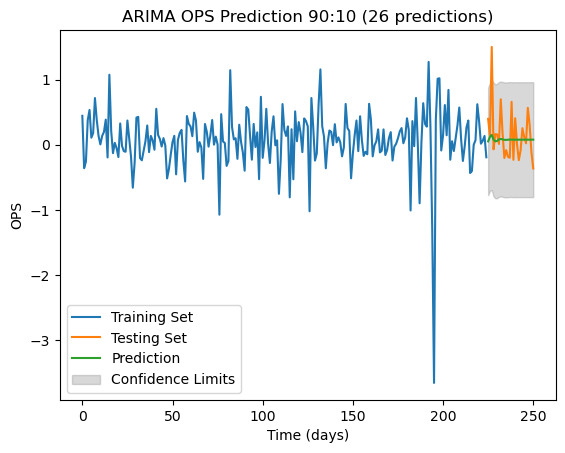

In [105]:
# Plot (full size)
plt.plot(train_data, label='Training Set')
plt.plot(test_data, label='Testing Set')
plt.plot(prediction, label='Prediction')
plt.fill_between(prediction.index,cf[0], cf[1], color='grey', alpha=0.3, label='Confidence Limits')
plt.title('ARIMA OPS Prediction 90:10 (' + str(len(prediction)) + ' predictions)')
plt.xlabel('Time (days)')
plt.ylabel('OPS')
plt.legend()
plt.show()

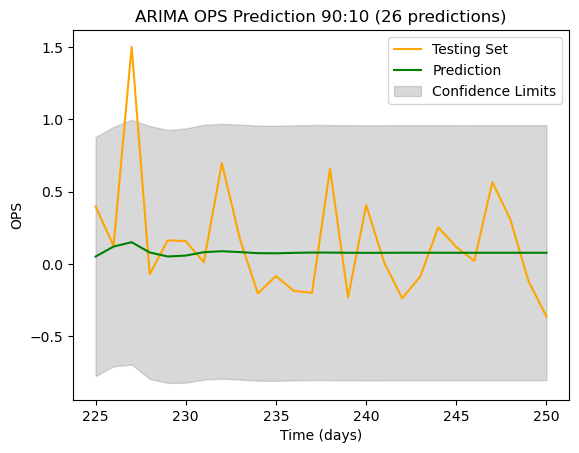

In [106]:
# Plot (Zoomed in)
plt.plot(test_data, label='Testing Set', color='orange')
plt.plot(prediction, label='Prediction', color='green')
plt.fill_between(prediction.index,cf[0], cf[1], color='grey', alpha=0.3, label='Confidence Limits')
plt.title('ARIMA OPS Prediction 90:10 (' + str(len(prediction)) + ' predictions)')
plt.xlabel('Time (days)')
plt.ylabel('OPS')
plt.legend()
plt.show()

In [107]:
# Evaluate
mse = mean_squared_error(test_data, prediction)
mae = mean_absolute_error(test_data, prediction)
#mape = mean_absolute_percentage_error(test_data, prediction)
r2 = r2_score(test_data, prediction)
#smae = calcsmape(test_data, prediction)
accuracy_table.loc["90:10"] = {'Mean Squared Error' : mse, 'Mean Absolute Error' : mae, 'R-Squared Value' : r2}
accuracy_table

,Mean Squared Error,Mean Absolute Error,R-Squared Value
Train:Test Split,,,
80:20,0.135490,0.267398,-0.086041
90:10,0.148167,0.276907,0.018893


TEST SIZE = 5%

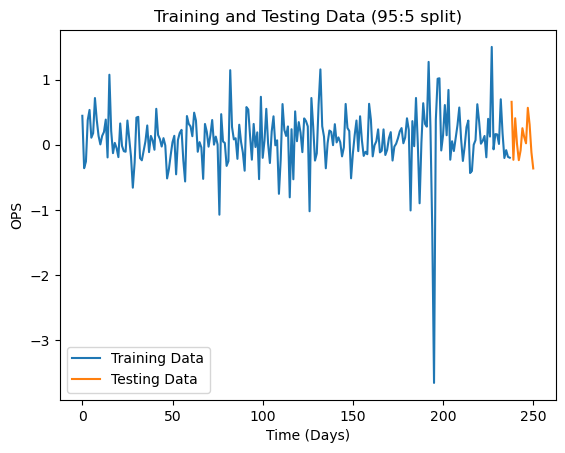

In [108]:
# Split data
train_data, test_data = train_test_split(data, test_size=0.05, shuffle=False)
plt.plot(train_data, label="Training Data")
plt.plot(test_data, label="Testing Data")
plt.title("Training and Testing Data (95:5 split)")
plt.xlabel("Time (Days)")
plt.ylabel("OPS")
plt.legend()
plt.show()

(1, 0, 4)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  238
Model:               SARIMAX(1, 0, 4)   Log Likelihood                -131.155
Date:                Wed, 23 Oct 2024   AIC                            276.310
Time:                        09:59:15   BIC                            300.616
Sample:                             0   HQIC                           286.106
                                - 238                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1610      0.035      4.567      0.000       0.092       0.230
ar.L1         -0.9069      0.071    -12.723      0.000      -1.047      -0.767
ma.L1          0.9882      0.097     10.16

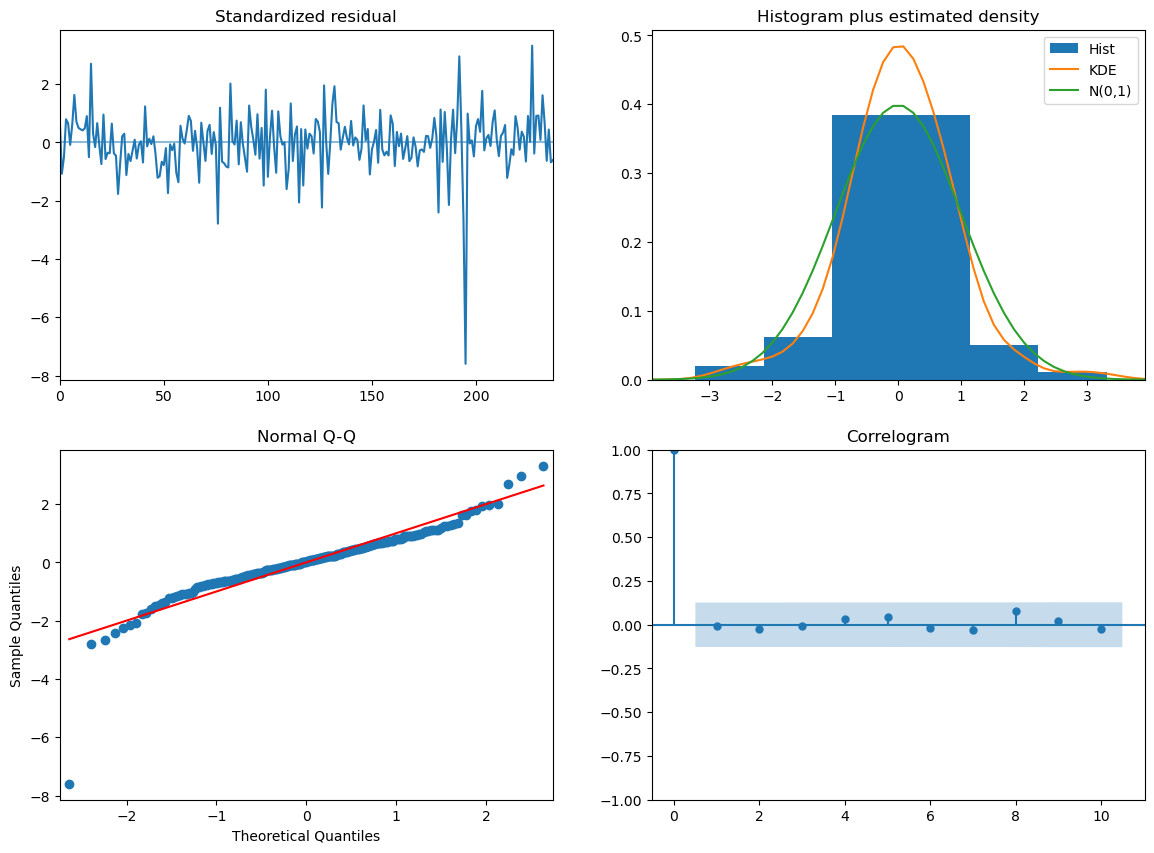

In [109]:
# Fit model
model = auto_arima(train_data, seasonal=False, stepwise=True)
print(model.order)
print(model.summary())
model.plot_diagnostics(figsize=(14,10))
plt.show()

In [110]:
# Make prediction
prediction, confint = model.predict(n_periods=len(test_data), return_conf_int=True)
cf = pd.DataFrame(confint)
print(prediction)

238    0.125097
239    0.146118
240    0.236842
241    0.028531
242    0.135126
243    0.038453
244    0.126128
245    0.046614
246    0.118727
247    0.053326
248    0.112639
249    0.058847
250    0.107632
dtype: float64


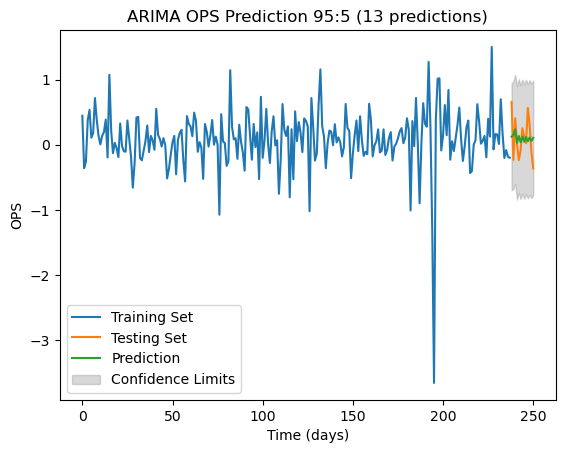

In [111]:
# Plot (full size)
plt.plot(train_data, label='Training Set')
plt.plot(test_data, label='Testing Set')
plt.plot(prediction, label='Prediction')
plt.fill_between(prediction.index,cf[0], cf[1], color='grey', alpha=0.3, label='Confidence Limits')
plt.title('ARIMA OPS Prediction 95:5 (' + str(len(prediction)) + ' predictions)')
plt.xlabel('Time (days)')
plt.ylabel('OPS')
plt.legend()
plt.show()

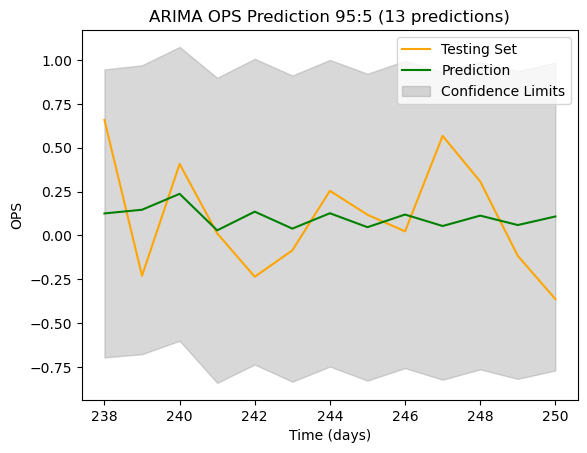

In [112]:
# Plot (Zoomed in)
plt.plot(test_data, label='Testing Set', color='orange')
plt.plot(prediction, label='Prediction', color='green')
plt.fill_between(prediction.index,cf[0], cf[1], color='grey', alpha=0.3, label='Confidence Limits')
plt.title('ARIMA OPS Prediction 95:5 (' + str(len(prediction)) + ' predictions)')
plt.xlabel('Time (days)')
plt.ylabel('OPS')
plt.legend()
plt.show()

In [113]:
# Evaluate
mse = mean_squared_error(test_data, prediction)
mae = mean_absolute_error(test_data, prediction)
#mape = mean_absolute_percentage_error(test_data, prediction)
r2 = r2_score(test_data, prediction)
#smae = calcsmape(test_data, prediction)
accuracy_table.loc["95:5"] = {'Mean Squared Error' : mse, 'Mean Absolute Error' : mae, 'R-Squared Value' : r2}
accuracy_table

,Mean Squared Error,Mean Absolute Error,R-Squared Value
Train:Test Split,,,
80:20,0.135490,0.267398,-0.086041
90:10,0.148167,0.276907,0.018893
95:5,0.091924,0.249539,0.024161


TEST SIZE = 2.5%

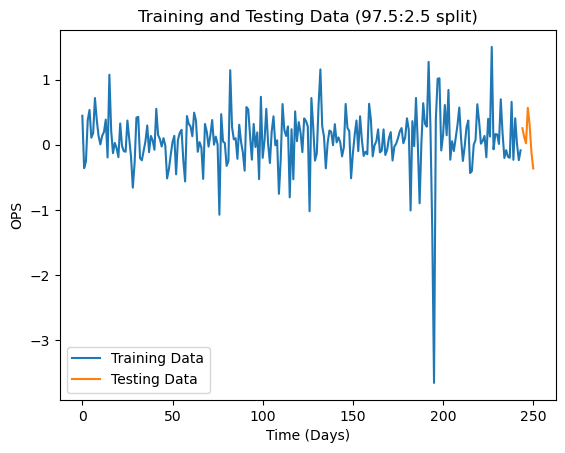

In [114]:
# Split data
train_data, test_data = train_test_split(data, test_size=0.025, shuffle=False)
plt.plot(train_data, label="Training Data")
plt.plot(test_data, label="Testing Data")
plt.title("Training and Testing Data (97.5:2.5 split)")
plt.xlabel("Time (Days)")
plt.ylabel("OPS")
plt.legend()
plt.show()

(1, 0, 4)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  244
Model:               SARIMAX(1, 0, 4)   Log Likelihood                -133.440
Date:                Wed, 23 Oct 2024   AIC                            280.881
Time:                        09:59:25   BIC                            305.361
Sample:                             0   HQIC                           290.740
                                - 244                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1599      0.034      4.673      0.000       0.093       0.227
ar.L1         -0.8947      0.073    -12.177      0.000      -1.039      -0.751
ma.L1          0.9652      0.100      9.65

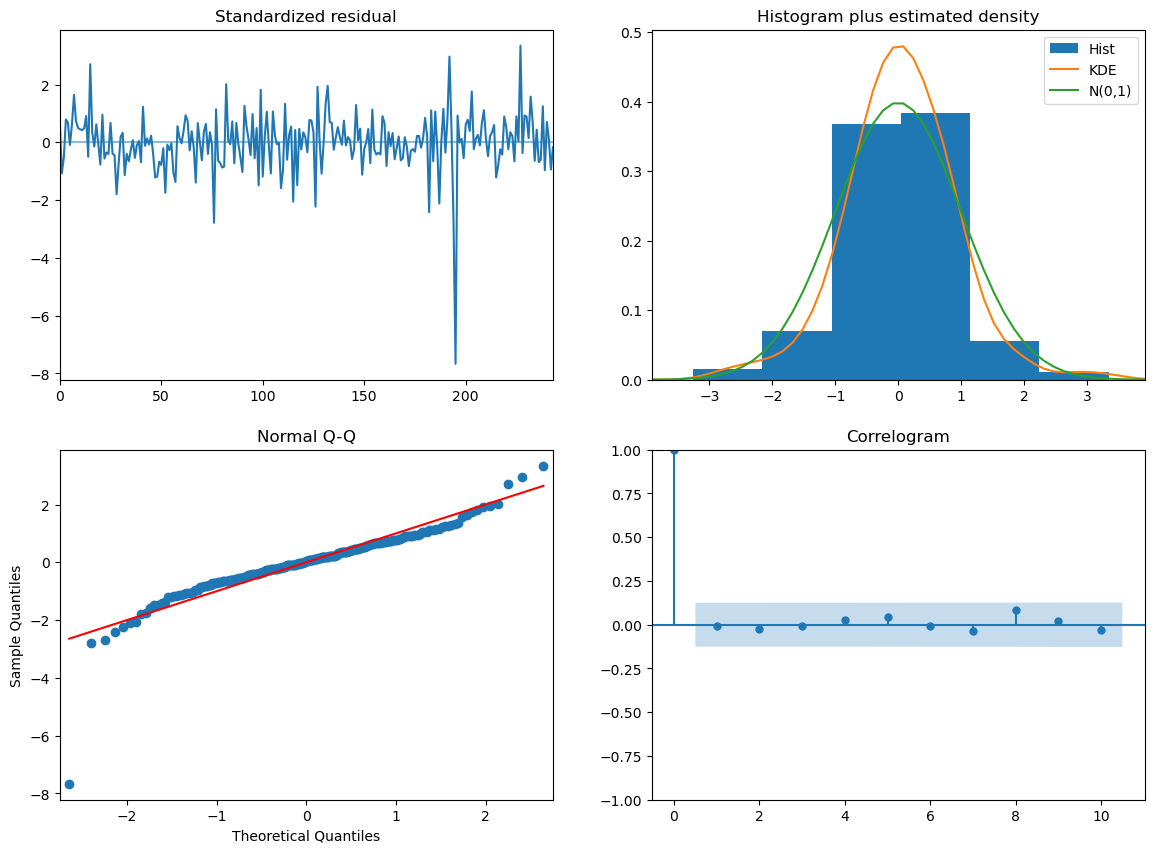

In [115]:
# Fit model
model = auto_arima(train_data, seasonal=False, stepwise=True)
print(model.order)
print(model.summary())
model.plot_diagnostics(figsize=(14,10))
plt.show()

In [116]:
# Make prediction
prediction, confint = model.predict(n_periods=len(test_data), return_conf_int=True)
cf = pd.DataFrame(confint)
print(prediction)

244    0.107723
245    0.235279
246    0.106287
247    0.087682
248    0.081438
249    0.087024
250    0.082026
dtype: float64


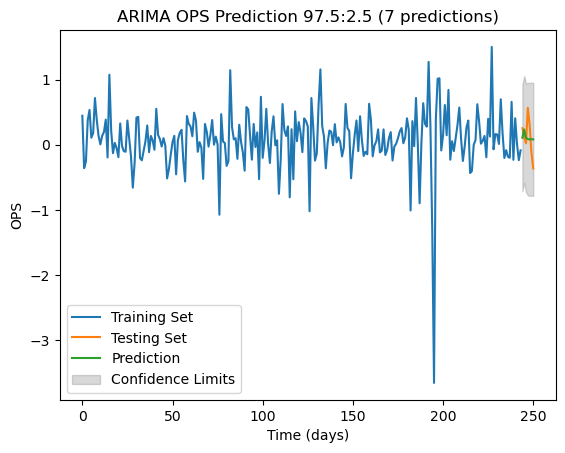

In [117]:
# Plot (full size)
plt.plot(train_data, label='Training Set')
plt.plot(test_data, label='Testing Set')
plt.plot(prediction, label='Prediction')
plt.fill_between(prediction.index,cf[0], cf[1], color='grey', alpha=0.3, label='Confidence Limits')
plt.title('ARIMA OPS Prediction 97.5:2.5 (' + str(len(prediction)) + ' predictions)')
plt.xlabel('Time (days)')
plt.ylabel('OPS')
plt.legend()
plt.show()

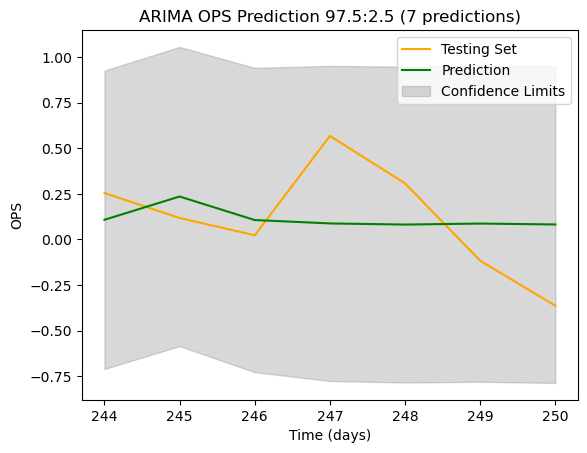

In [118]:
# Plot (Zoomed in)
plt.plot(test_data, label='Testing Set', color='orange')
plt.plot(prediction, label='Prediction', color='green')
plt.fill_between(prediction.index,cf[0], cf[1], color='grey', alpha=0.3, label='Confidence Limits')
plt.title('ARIMA OPS Prediction 97.5:2.5 (' + str(len(prediction)) + ' predictions)')
plt.xlabel('Time (days)')
plt.ylabel('OPS')
plt.legend()
plt.show()

In [119]:
# Evaluate
mse = mean_squared_error(test_data, prediction)
mae = mean_absolute_error(test_data, prediction)
#mape = mean_absolute_percentage_error(test_data, prediction)
r2 = r2_score(test_data, prediction)
#smae = calcsmape(test_data, prediction)
accuracy_table.loc["97.5:2.5"] = {'Mean Squared Error' : mse, 'Mean Absolute Error' : mae, 'R-Squared Value' : r2}
accuracy_table

# Final accuracy table

,Mean Squared Error,Mean Absolute Error,R-Squared Value
Train:Test Split,,,
80:20,0.135490,0.267398,-0.086041
90:10,0.148167,0.276907,0.018893
95:5,0.091924,0.249539,0.024161
97.5:2.5,0.080506,0.243261,-0.020426


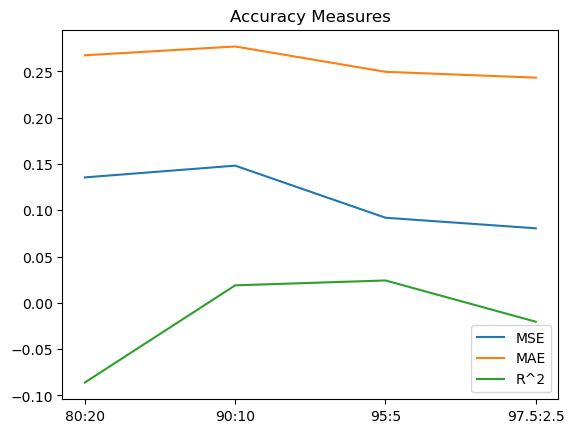

In [120]:
# Graph accuracy table
plt.plot(accuracy_table['Mean Squared Error'], label='MSE')
plt.plot(accuracy_table['Mean Absolute Error'], label='MAE')
#plt.plot(accuracy_table['Mean Absolute Percentage Error'], label='MAPE')
plt.plot(accuracy_table['R-Squared Value'], label='R^2')
#plt.plot(accuracy_table['Symmetric Mean Absolute Error'], label='SMAE')
plt.title('Accuracy Measures')
plt.legend()
plt.show()